In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA 
from datetime import datetime, timedelta


## Generate some data 
As pure moving average data are not normally available in real world

$y_t = 50 + 0.4 \epsilon_{t-1} + 0.3\epsilon_{t-2} + \epsilon_t$

$\epsilon_t \sim N(0,1)$


In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start = '9/1/2019', end = '1/1/2020')

In [4]:
mu = 50
series = []

for t in range(1, len(date_index) + 1):
    series.append(mu + 0.4 * errors[t-1] + 0.3 * errors[t-2] + errors[t])


In [5]:
Data = pd.Series(data = series, index = date_index)

In [6]:
Data

2019-09-01    49.415596
2019-09-02    48.547452
2019-09-03    51.465608
2019-09-04    50.892051
2019-09-05    52.700872
                ...    
2019-12-28    49.888987
2019-12-29    51.328447
2019-12-30    51.814612
2019-12-31    51.989928
2020-01-01    50.420075
Freq: D, Length: 123, dtype: float64

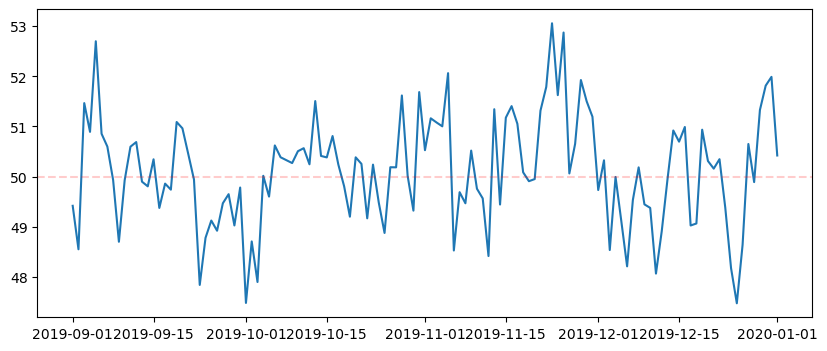

In [7]:
plt.figure(figsize = (10,4))
plt.plot(Data)
plt.axhline(mu, linestyle = '--', color = 'r', alpha = 0.2)

## ACF

<BarContainer object of 10 artists>

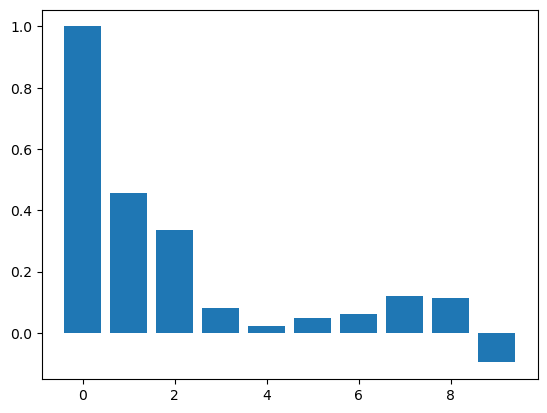

In [8]:
acf_vals = acf(Data)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags]) ## plt.bar(x, y)

## PACF

<BarContainer object of 20 artists>

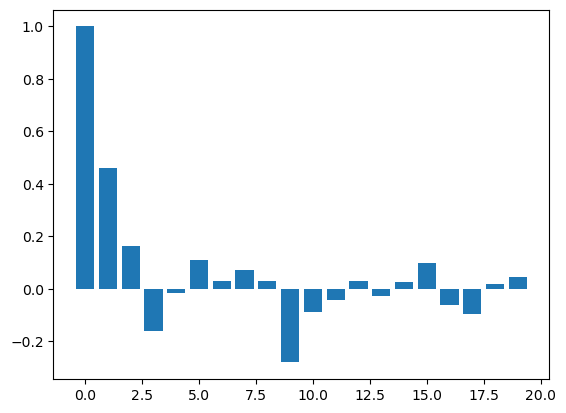

In [13]:
pacf_vals = pacf(series)
num_lag = 20
plt.bar(range(num_lag), pacf_vals[:num_lag])

### NOTE:
If we use MA(2) then we can only predict two days in future, after 2 days it will just predict mean value 

## Get train and test data

In [21]:
train_end = datetime(2019, 12, 30)
test_end = datetime(2020, 1, 1) # only 2 days in test data becuase we will be using MA(2) -- which can only predict two days in future.

train_data = Data[:train_end]
test_data = Data[train_end + timedelta(days = 1) : test_end]

In [22]:
test_data

2019-12-31    51.989928
2020-01-01    50.420075
Freq: D, dtype: float64

In [23]:
train_data

2019-09-01    49.415596
2019-09-02    48.547452
2019-09-03    51.465608
2019-09-04    50.892051
2019-09-05    52.700872
                ...    
2019-12-26    48.637853
2019-12-27    50.649421
2019-12-28    49.888987
2019-12-29    51.328447
2019-12-30    51.814612
Freq: D, Length: 121, dtype: float64

## Fit ARIMA model

In [24]:
model = ARIMA(train_data , order = (0,0,2))

In [27]:
model_fit = model.fit()

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -164.787
Date:                Fri, 02 Aug 2024   AIC                            337.575
Time:                        20:52:47   BIC                            348.758
Sample:                    09-01-2019   HQIC                           342.117
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1047      0.152    329.621      0.000      49.807      50.403
ma.L1          0.3825      0.109      3.512      0.000       0.169       0.596
ma.L2          0.3812      0.085      4.459      0.000       0.214       0.549
sigma2         0.8892      0.116      7.651      0.000       0.661       1.117
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.80   Prob(JB):                         0.99
Heteroskedasticity (H):               1.60   Skew:                             0.03
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Actual vs Predicted Model

We see the coeff of ma.L1 and ma.L2 is very close to the coeff of lag 1 and lag 2 term in the actual time series that we had i.e 

$y_t = 50 + 0.4 \epsilon_{t-1} + 0.3\epsilon_{t-2} + \epsilon_t$

the predicted model is 

$y_t = 50.1047 + 0.3825 \epsilon_{t-1} + 0.3812 \epsilon_{t-2} $


In [31]:
## get prediction for test_data

predictions = model_fit.predict(start = test_data.index[0], end = test_data.index[-1])

In [32]:
residual = test_data - predictions 

(array([18253., 18254., 18255., 18256., 18257., 18258., 18259., 18260.,
        18261., 18262.]),
 [Text(18253.0, 0, '2019-12-23'),
  Text(18254.0, 0, '2019-12-24'),
  Text(18255.0, 0, '2019-12-25'),
  Text(18256.0, 0, '2019-12-26'),
  Text(18257.0, 0, '2019-12-27'),
  Text(18258.0, 0, '2019-12-28'),
  Text(18259.0, 0, '2019-12-29'),
  Text(18260.0, 0, '2019-12-30'),
  Text(18261.0, 0, '2019-12-31'),
  Text(18262.0, 0, '2020-01-01')])

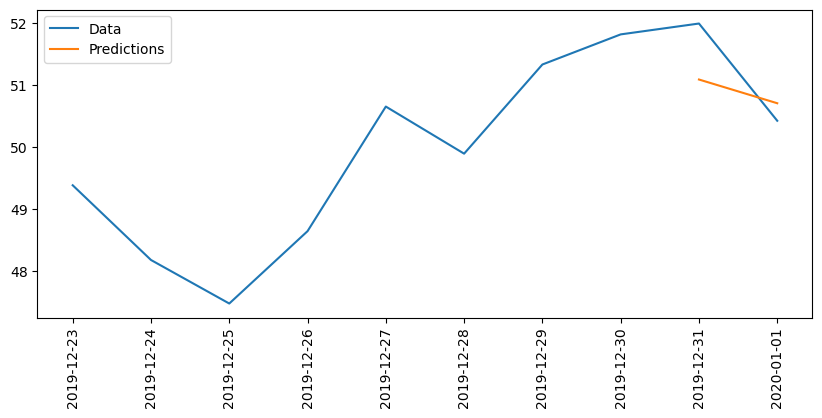

In [36]:
plt.figure(figsize = (10, 4))

plt.plot(Data[-10:])
plt.plot(predictions)

plt.legend(['Data', 'Predictions'])
plt.xticks(rotation = 90)